In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets as widgets
from ipywidgets.widgets.interaction import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
import os
from util import *
import lspn
import shtools
import problems


 # Use interactive matplotlib backend, which runs in the browser
%matplotlib notebook

In [2]:
def get_coefficient_field(x, pnb, coeff_index=0):
    u0 = np.zeros( (pnb.domain.res_x, pnb.domain.res_y) )
    for voxel_i in range(pnb.domain.res_x):
        for voxel_j in range(pnb.domain.res_y):
            i = pnb.get_global_index(voxel_i, voxel_j, coeff_index)
            u0[voxel_i, voxel_j] = x[i]
    return u0

In [3]:
#id = "checkerboard_blur10.0"
id = "checkerboard_blur10.0_term1"
#id = "checkerboard"
#id = "checkerboard_term1"
data = lspn.load_pn_solution("C:/projects/epfl/epfl17/python/sopn/solution_{}.mat".format(id))

A_real = data["A_real"]
x_real = data["x_real"]
b_real = data["b_real"]
pnb = data["pnb"]

loading PN solution from C:/projects/epfl/epfl17/python/sopn/solution_checkerboard_blur10.0_term1.mat


C:\Users\dk402_000\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:136: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
problem = {}

# L -----
x_complex = pnb.to_complex(data["x_real"])
coefficient_grids = [problems.Constant(0.0) for i in range(shtools.numSHCoeffs(pnb.N))]
for i in range(pnb.numCoeffs):
    (l,m) = pnb.lmIndex(i)
    offset = pnb.get_unknown_offset(i)*0.5
    grid = problems.CoefficientGrid(pnb.domain, pnb.numCoeffs, i, offset, x_complex )
    coefficient_grids[shtools.shIndex(l,m)] = grid
problem["L"] = problems.SHEXP( pnb.N, coefficient_grids )

In [5]:
def make_plot():
    global msg
    figsize = plt.figaspect(1/2)
    #fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    fig = plt.figure(figsize=figsize);
    ax = [None, None]
    ax[0] = fig.add_subplot(121)
    ax[1] = fig.add_subplot(122, projection='polar')
    #ax[1] = fig.add_subplot(122)

    
    # Draw an empty image
    img_view = ax[0].imshow(np.zeros((1,1)), cmap='jet', origin='lower')
    
    # Add a nice color bar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    # Add an empty plot of the SH coefficients
    plot_view = ax[1].plot(np.zeros((1)))[0]
    #ax[1].set_aspect('scaled')
    #plt.axis('scaled')
    ax[1].set(adjustable="datalim")
    ax[1].set_rmax(1)
    ax[1].set_rticks([0.5, 1])  # less radial ticks
    
    result = { 'img_view' : img_view,
               'img_ax' : ax[0],
               'plot_view' : plot_view,
               'plot_ax' : ax[1] }
    
    def on_click(event):
        global msg
        if event.inaxes is not ax[0] or 'on_click_handler' not in result:
            return
        #f = open("c:/projects/epfl/epfl17/python/test.out", "w")
        #f.write("{} {}".format(event.xdata, event.ydata))
        #f.close()

        #result['on_click_handler'](np.uint32([event.ydata, event.xdata]))
        result['on_click_handler'](np.array([event.ydata, event.xdata]))

    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.tight_layout()

    return result

def plot_interact(plot):
    #def redraw(slice_index, coeff_index, dataset_index):
    def redraw(coeff_index):
        img_view = plot['img_view']
        plot_view = plot['plot_view']
        plot_ax = plot['plot_ax']
            
        # Extract a slice
        #data = scipy.io.loadmat("C:/projects/epfl/epfl17/python/sopn/debug_terms/data_term1.mat")
        #term_index = 1
        #x_term = data["x_term{}".format(term_index)].reshape(data["x_term{}".format(term_index)].shape[0])
        #A = scipy.io.loadmat("C:/projects/epfl/epfl17/python/sopn/debug_terms/system_{}_term{}.mat".format(id, 1))["A"]
        u = get_coefficient_field(x_real, pnb, coeff_index )
        print( "min={} max={}".format(np.min(u), np.max(u)) )

        
        # Update the plot
        img_view.set_data(u.T)
        #img_view.set_clim(vmin=0, vmax=np.percentile(data_slice, 99))
        img_view.set_clim(vmin=np.min(u), vmax=np.max(u))
        #img_view.set_extent((0, data_slice.shape[0], 0, data_slice.shape[1]))
        img_view.set_extent((pnb.domain.bound_min[0], pnb.domain.bound_max[0], pnb.domain.bound_min[1], pnb.domain.bound_max[1]))
        
        def on_click_handler(pos):
            #pos2 = np.array([pos[1], pos[0]])
            #pos2 = np.array([3.5, 2.0])
            #pos2 = np.array([2.0, 3.5])
            L = problem["L"]
            
            plot_y = np.arange(0, 2, 0.01)
            plot_x = 2 * np.pi * plot_y
            
            for i in range(plot_x.shape[0]):
                phi = plot_x[i]
                omega = shtools.sphericalDirection(np.pi*0.5, phi)
                plot_y[i] = L(np.array([pos[1], pos[0]]), omega)
            
            plot_y = plot_y/np.max(plot_y)
            plot_view.set_data(plot_x, plot_y)
            #plot_view.set_rmax(2)
        
        plot['on_click_handler'] = on_click_handler

    #slice_index_widget = widgets.IntSlider(
    #    min=0,
    #    max=127,
    #    value=64,
    #    description='Slice'
    #)
   
    coeff_index_widget = widgets.IntSlider(
        min=0,
        max=2,
        value=0,
        description='coefficient'
    )
    
    #dataset_index_widget = widgets.Dropdown(
    #    options=[('P1 solution', 0), ('P2 solution', 1)],
    #    value=0,
    #    description='Dataset'
    #)
    
    #interact(redraw, dataset_index=dataset_index_widget, slice_index=slice_index_widget, coeff_index=coeff_index_widget)
    interact(redraw, coeff_index=coeff_index_widget)

<IPython.core.display.Javascript object>


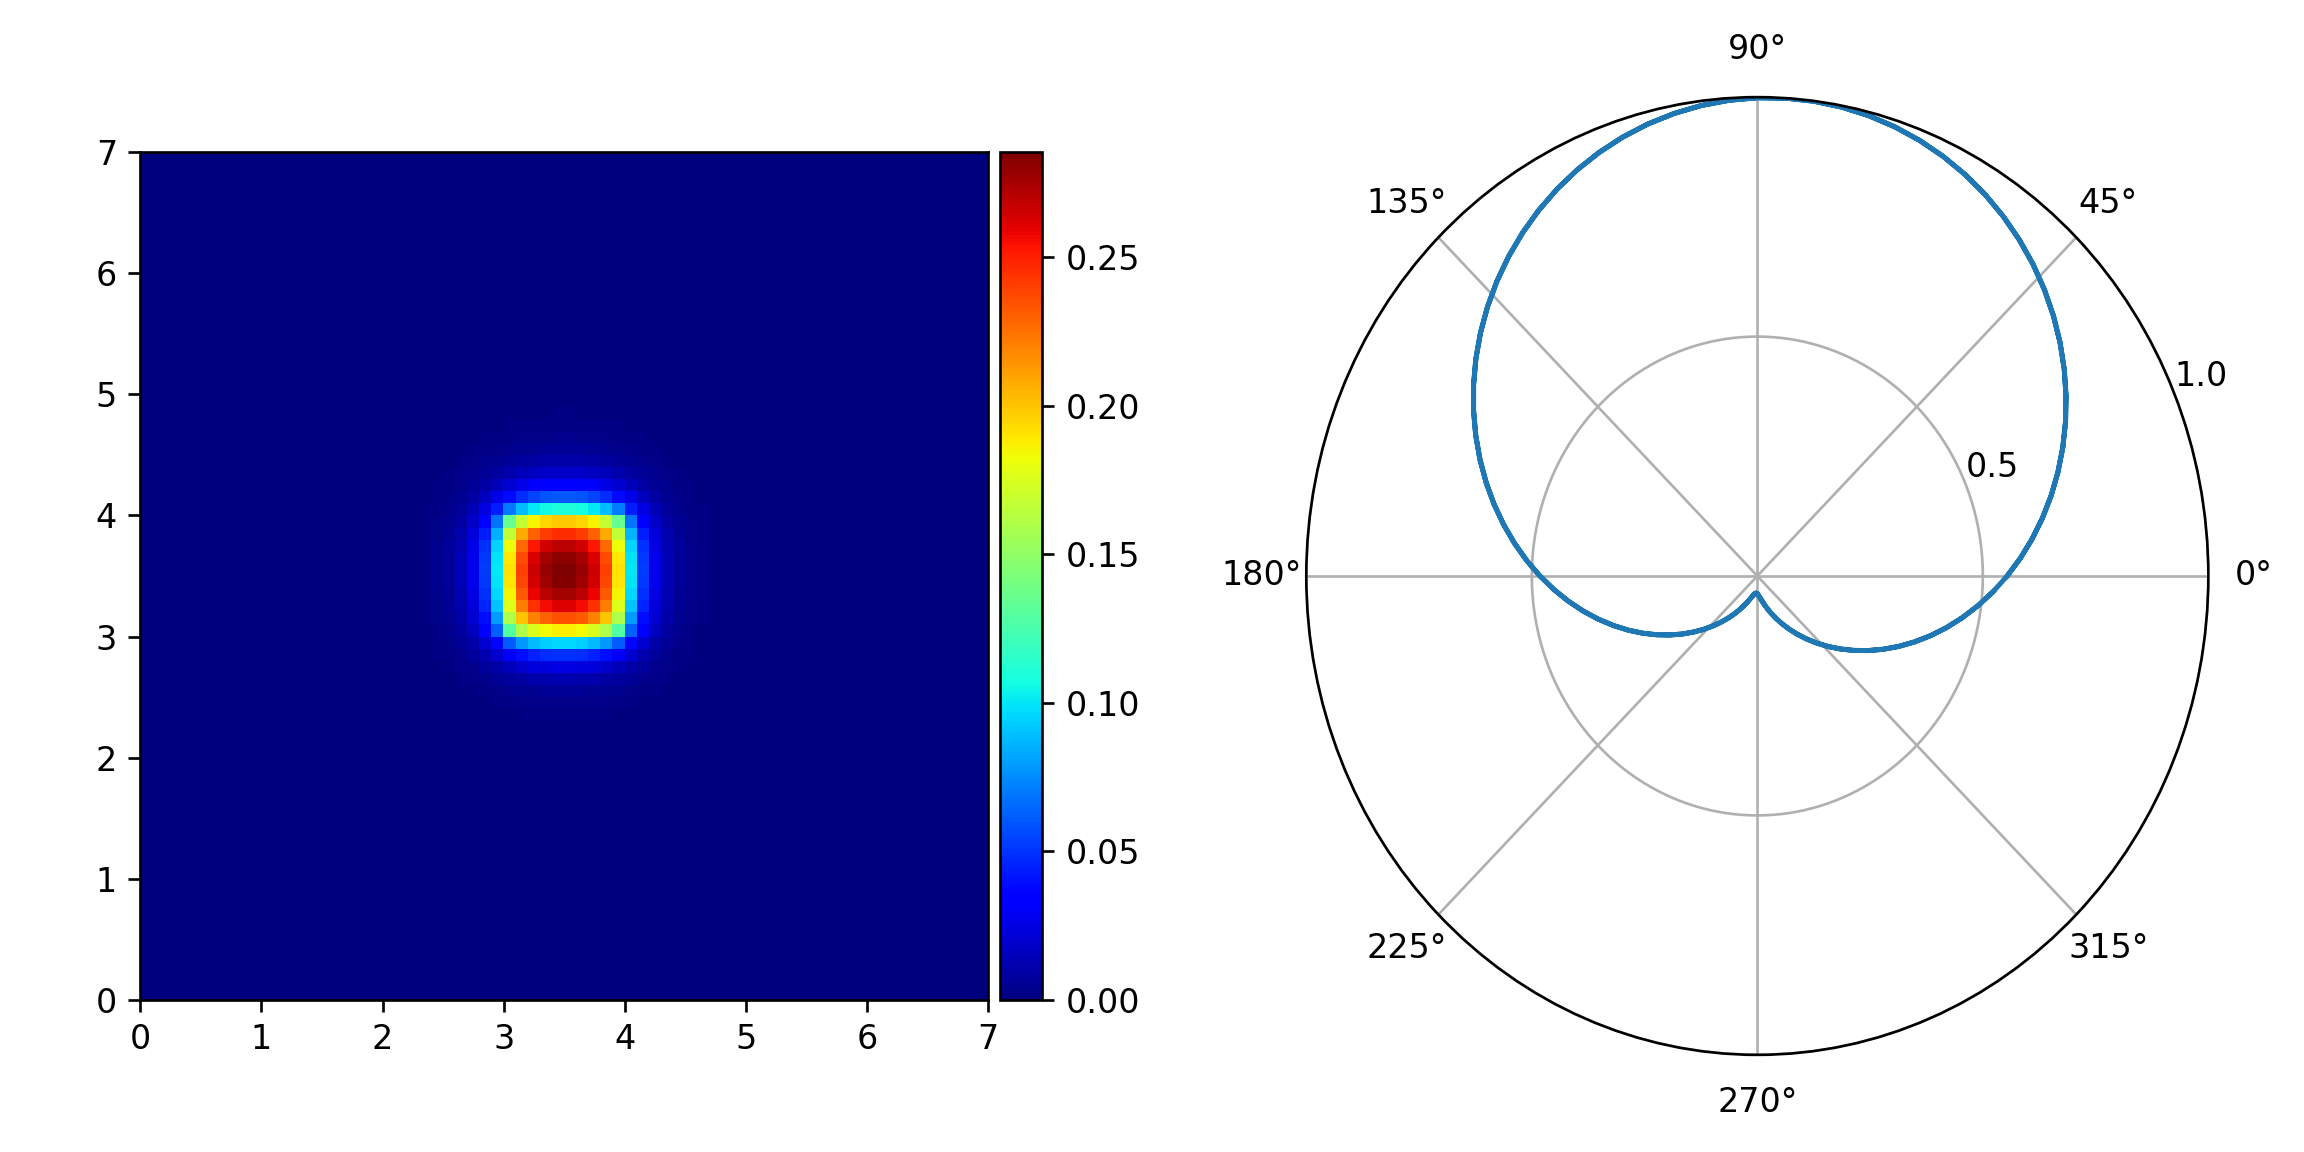

In [6]:
plot = make_plot()

In [7]:
plot_interact(plot)

min=-4.425768715585457e-07 max=0.28530409613967483
